In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib widget
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_blobs

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


ModuleNotFoundError: No module named 'public_tests_a1'

In [ ]:
# function for generate data with addes noise
def gen_data(m, seed=1, scale=0.7): 
    c = 0
    x_train = np.linspace(0, 49, m)
    np.random.seed(seed)
    y_ideal = x_train **2 + c
    y_train = y_ideal + scale * y_ideal * (np.random.sample(size=(m,)) - 0.5)
    x_ideal = x_train
    return x_train, y_train, x_ideal, y_ideal

X, y, x_ideal, y_ideal = gen_data(m=18, seed=2, scale=0.7)

print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train:np.ndarray
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)



X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


The 'ideal' curve is shown for reference

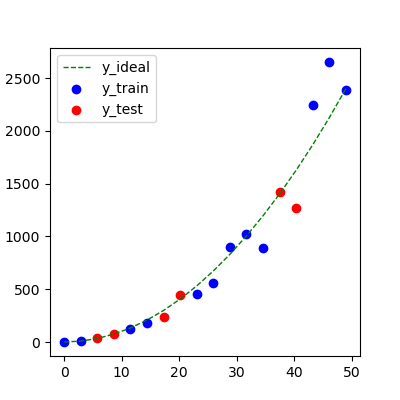

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_ideal, y_ideal, '--', color='green', label='y_ideal', lw=1)
ax.scatter(X_train, y_train, color='blue', label='y_train')
ax.scatter(X_test, y_test, color='red', label='y_test')
ax.legend(loc='upper left')
plt.show()

## Linear model

In [ ]:
# Create my custom Linear model
class Lin_model:
    def __init__(self, degree, regularization=False, lambda_=0):
        if regularization: 
            self.linear_model = Ridge(alpha=lambda_)
        else: 
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree=degree, include_bias=False)
        self.scaler = StandardScaler()
        
    def fit(self, X_train:np.ndarray, y_train): 
        # Just fit the data. mapping and scaling are not repeated
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1, 1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train)
    
    def predict(self, X: np.ndarray):
        X_mapped = self.poly.transform(X.reshape(-1, 1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return yhat
    def get_parameters(self): 
        weights = self.linear_model.coef_
        bias = self.linear_model.intercept_
        return weights, bias
    
    def mse(self, y, yhat): 
        return mean_squared_error(y, yhat)/2

### Compare the performance on the training and test data

* Create and fit the model. ('fit' is another name for training model or running gradient descent)
* Compute error on the training set
* Compute error on the test set

In [ ]:
# Use high degree polynomial model
degree = 10

model = Lin_model(degree=degree)
model.fit(X_train, y_train)

# Predict on training set
yhat = model.predict(X_train)
# Predict on test set
yhat_test = model.predict(X_test)
print(f'yhat: {yhat}')
print(f'yhat_test: {yhat_test}')
# Compute MSEs of training set and test set
train_mse = model.mse(yhat, y_train)
test_mse = model.mse(yhat_test, y_test)

print(f"training err {train_mse:0.2f}, test err {test_mse:0.2f}")

yhat: [ 2.24314269e+03  1.25105368e+02  5.57647001e+00  8.76088690e+02
 -7.35578481e-03  2.39135831e+03  2.65356292e+03  5.82757094e+02
  4.50123259e+02  8.84968452e+02  1.04291985e+03  1.83888967e+02]
yhat_test: [ 416.76305382  630.72877663  702.76143604 1121.45640474 1142.86709836
  476.46623723]
training err 58.01, test err 171215.01


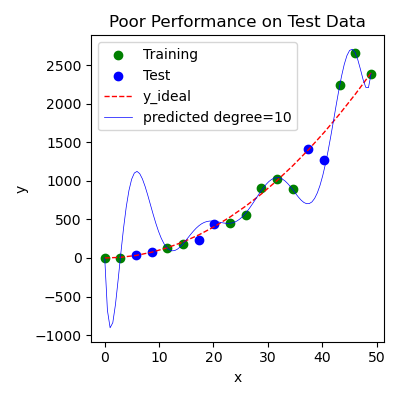

In [ ]:
plt.close('all')

fig, ax = plt.subplots(1,1, figsize=(4,4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
# To prove that the pred overfits the training set (if polynomial degree is high)
x_to_plot = np.linspace(X_train.min(), X_train.max(), 100)
y_to_plot = model.predict(x_to_plot)

ax.scatter(X_train, y_train, color='green', label='Training')
ax.scatter(X_test, y_test, color='blue', label='Test')
ax.plot(x_ideal, y_ideal, '--', label='y_ideal', color='red', lw=1)
ax.plot(x_to_plot, y_to_plot, color='blue', label=f"predicted degree={degree}", lw=0.5)
ax.legend()
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_title('Poor Performance on Test Data')  
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()
plt.show()

The test data shows the model will not work well on new data. If we use test data the guide improvement, then the model will perform well on the test data, but the test data was meant to represent new data. So we need yet another set of new data to test new data performance

The proposal is to separate the data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied 
| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |

In [ ]:
# Generate data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

# Split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


# Bias and Variance

### Plot Train, Cross-Validation, Test

Text(0.5, 1.0, 'Traing, CV, TEST')

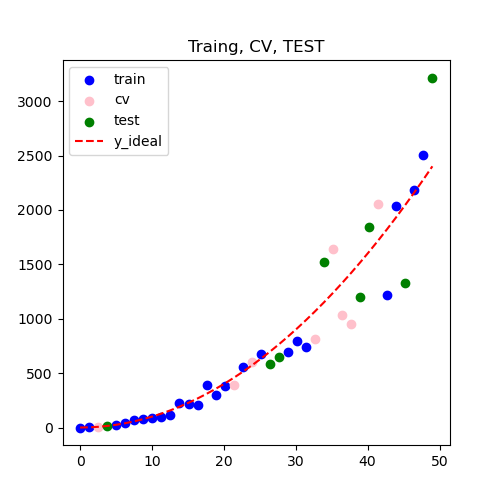

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_train, y_train, color='blue', label='train')
ax.scatter(X_cv, y_cv, color='pink', label='cv')
ax.scatter(X_test, y_test, color='green', label='test')
ax.plot(x_ideal, y_ideal, '--', color='red', label='y_ideal')


ax.legend(loc='upper left')
ax.set_title('Traing, CV, TEST')

### Finding the optimal degree

In [ ]:
max_degree = 10 

err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x_to_plot = np.linspace(np.min(X), np.max(X), 100)
# y_pred contains prediction on 'x_to_plot' of polynomial degree model
y_pred = np.zeros(shape=(100, max_degree))

for degree in range(max_degree): 
    # Create model and train the model
    model = Lin_model(degree=degree+1)
    model.fit(X_train, y_train)
    
    # Prediction on X_train and X_cv
    yhat = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    err_train[degree] = model.mse(yhat, y_train)
    err_cv[degree] = model.mse(yhat_cv, y_cv)
    
    y_pred[:, degree] = model.predict(x_to_plot)
    

In [ ]:
optimal_degree = np.argmin(err_cv) + 1
optimal_degree

2

In [ ]:
cpts = list(range(1, max_degree + 1))

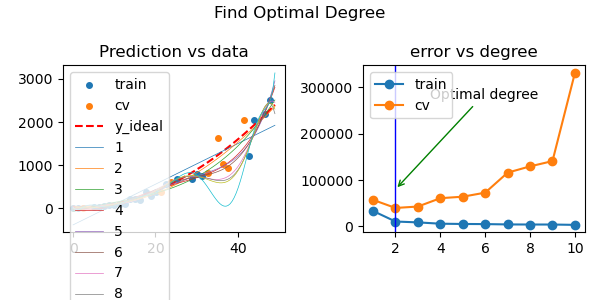

In [ ]:
ax1: plt.Axes
ax2: plt.Axes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False


ax1.scatter(X_train, y_train, s=16, label='train')
ax1.scatter(X_cv, y_cv, s=16, label='cv')
ax1.plot(x_ideal, y_ideal, '--', color='red', label='y_ideal')

for degree in range(max_degree):
    ax1.plot(x_to_plot, y_pred[:, degree], lw=0.5, label=f'{degree + 1}') 

ax1.legend(loc='upper left')   
ax1.set_title('Prediction vs data') 

ax2.plot(cpts, err_train, label='train', marker='o')
ax2.plot(cpts, err_cv, label='cv', marker='o')
ax2.legend(loc='upper left')
ax2.set_title('error vs degree')

ax2.axvline(optimal_degree, lw=1, color = 'blue')
ax2.annotate('Optimal degree', xy=(optimal_degree, 80000), xycoords='data', xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10, arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='green'))

fig.suptitle("Find Optimal Degree",fontsize = 12)
plt.tight_layout()

- On the left plot, the solid lines represent the predictions from the models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point.
- On the right: 
  - The error on the trained data (blue) decreases as the model complexity increases as expected
  - The error on the cross-validation data initially decreases as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to generalize)

## Tunning Regularization
Utilizing regularization to reduce overfitting

Let's demonstate this by starting with a high degree polynomial and varying regularization parameter

In [ ]:
# High polynomial degree
degree = 10

lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)

err_train = np.zeros(num_steps)
x_to_plot = np.linspace(0,int(X.max()),100) 
err_cv = np.zeros(num_steps)
y_pred = np.zeros(shape=(100, num_steps))

for i in range(num_steps): 
    # Initialize and train the model
    lambda_ = lambda_range[i]
    model = Lin_model(degree=degree, regularization=True, lambda_=lambda_)
    model.fit(X_train, y_train)
    
    # Make predictions on train and cross-validation set
    yhat = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Compute MSEs of train and cross-validation set
    err_train[i] = model.mse(yhat, y_train)
    err_cv[i] = model.mse(yhat_cv, y_cv)
    
    y_pred[:, i] = model.predict(x_to_plot)
    
optimal_reg_idx = np.argmin(err_cv)
print(optimal_reg_idx)

7


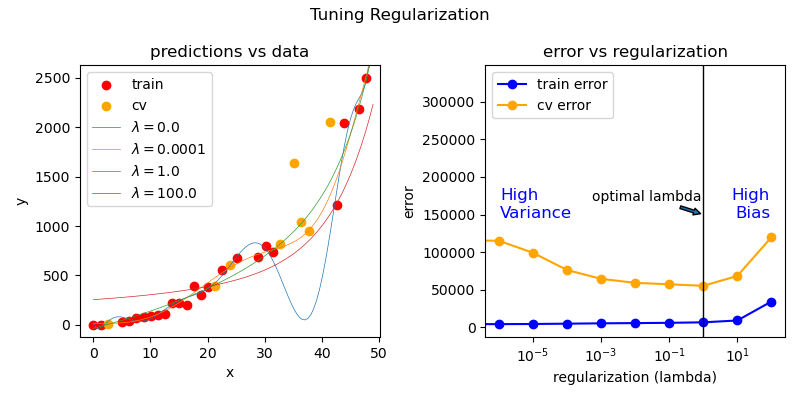

No such comm: 0f40cb11a5da4bb38e5d3448e99db6cb


In [ ]:
plt.close("all")

def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color =  "orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color =  "blue", marker='o')
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color =  "orange", marker='o')
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color =  "blue")
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color =  "blue")
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plt_tune_regularization(X_train, y_train, X_cv, y_cv, x_to_plot, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that a regulirization, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. Notice that the polynomial degree was set to 10 so as to make a example of overfitting model

### Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance

In [ ]:
# Get more data
def tune_m(): 
    m = 50
    m_range = np.array(m*np.arange(1, 16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)
    err_cv = np.zeros(num_steps)
    y_pred = np.zeros(shape=(100, num_steps))
    
    for i in range(num_steps): 
        X, y, x_ideal, y_ideal = gen_data(m_range[i], seed=5, scale=0.7)
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
        x_to_plot = np.linspace(X.min(), X.max(), 100)
        
        # Initilize and train model
        model = Lin_model(degree=degree)
        model.fit(X_train, y_train)
        
        yhat = model.predict(X_train)
        yhat_cv = model.predict(X_cv)
        
        err_train[i] = model.mse(y_train, yhat)
        err_cv[i] = model.mse(y_cv, yhat_cv)
        
        y_pred[:, i] = model.predict(x_to_plot)
        
    return(X_train, y_train, X_cv, y_cv, x_to_plot, y_pred, err_train, err_cv, m_range,degree)
        

X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()


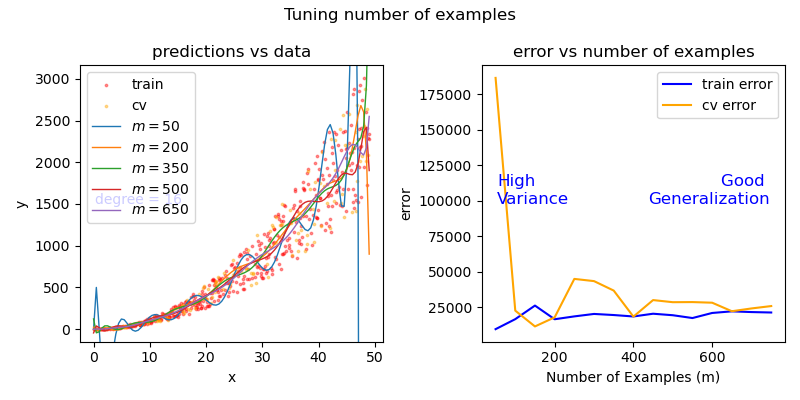

In [ ]:
def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False  

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color =  "orange", s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    # for i in range(0,len(m_range),3):
    for i in range(0,len(m_range), 3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color =  "blue")

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color =  "blue")
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color =  "orange")
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color =  "blue")
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color =  "blue")
    ax[1].legend()
    plt.tight_layout()
    plt.show()  

plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of `m` is the smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of training set and cross-validation set converge to similar values.

> Note that adding more additional data when the model has high bias (underfitting) doesn't improve performance

## Evaluating a Learning Algorithm (Neural network)
Above, you tuned aspects of polynomial regression model. Now, we will work with a neural network model

In [ ]:
def gen_blobs(): 
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-2, -1], [-2, 1], [-1, 0], [0, -1], [0, 1], [1, 0]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return X, y, centers, classes, std

# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# Split the data. Large CV population for demonstration

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.5, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.2, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


In [ ]:
print(np.unique(y_train))
print(X_train[:10])

[0 1 2 3 4 5]
[[-2.06686751  0.76935563]
 [ 0.78494786 -0.43994527]
 [ 0.18851996 -1.31766002]
 [-1.42114964 -0.3595942 ]
 [-1.8335913   0.97686109]
 [-0.46008707 -0.7257529 ]
 [ 1.67577147 -0.25278499]
 [ 0.16692369 -1.05896683]
 [-0.2120971  -0.96782784]
 [-1.97709962 -0.93636461]]


[[0. 0. 0. ... 3. 5. 5.]
 [0. 0. 0. ... 5. 5. 5.]
 [0. 0. 0. ... 5. 5. 5.]
 ...
 [1. 1. 1. ... 4. 4. 5.]
 [1. 1. 1. ... 4. 4. 4.]
 [1. 1. 1. ... 4. 4. 4.]]


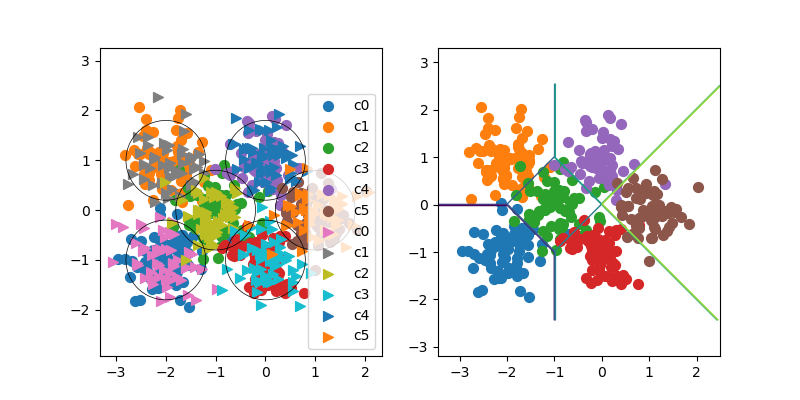

In [ ]:
classes = len(np.unique(y_train))

def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, linewidths=lw) 
    ax.axis('tight')
    
def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_mc_data(ax: plt.Axes, X, y, classes: int, class_labels=None, legend=False, size=50, m='o'): 
    for i in range(classes): 
        idx = np.where(y == i)
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1], marker=m, s=size, label=label)
    if legend: ax.legend(loc='lower right')
    ax.axis('equal')

# Plot the first ax
fig,ax = plt.subplots(1,2,figsize=(8,4))
plt_mc_data(ax=ax[0], X=X_train, y=y_train, classes=classes, legend=True)
plt_mc_data(ax=ax[0], X=X_cv, y=y_cv, classes=len(np.unique(y_cv)), legend=True, m='>')


# Add circles
css = np.unique(y_train)
for c in css: 
    circ = plt.Circle(centers[c], std* 2, fill=False, lw=0.5, )
    ax[0].add_patch(circ)
    
cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, )
    
# Plot the second ax
plt_mc_data(ax[1], X_train, y_train, classes=classes)
    

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validation (triangles) are shown. The interesting points are those fall in the ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?
On the right is an example of an 'ideal' model. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

## 5 - Model Complexity

### Complex model

Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [ ]:
tf.random.set_seed(1234)
model = Sequential([
    Dense(units=120, activation='relu'),
    Dense(units=40, activation='relu'),
    Dense(units=6, activation='linear'),

], name='Complex')

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01)
)

In [ ]:
model.fit(
    X_train, y_train, 
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 957us/step - loss: 0.9302
Epoch 2/1000
13/13 [==============================] - 0s 794us/step - loss: 0.3699
Epoch 3/1000
13/13 [==============================] - 0s 814us/step - loss: 0.2858
Epoch 4/1000
13/13 [==============================] - 0s 812us/step - loss: 0.2841
Epoch 5/1000
13/13 [==============================] - 0s 808us/step - loss: 0.2484
Epoch 6/1000
13/13 [==============================] - 0s 841us/step - loss: 0.2442
Epoch 7/1000
13/13 [==============================] - 0s 866us/step - loss: 0.2562
Epoch 8/1000
13/13 [==============================] - 0s 733us/step - loss: 0.2659
Epoch 9/1000
13/13 [==============================] - 0s 758us/step - loss: 0.2384
Epoch 10/1000
13/13 [==============================] - 0s 731us/step - loss: 0.2205
Epoch 11/1000
13/13 [==============================] - 0s 799us/step - loss: 0.2348
Epoch 12/1000
13/13 [==============================] - 0s 798us/step - loss: 0.2163
E

In [ ]:
model.summary()

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 120)               360       
                                                                 
 dense_10 (Dense)            (None, 40)                4840      
                                                                 
 dense_11 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________


1050/1050 [==============================] - 1s 629us/step
[0 0 0 0 0]
[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]]
1050/1050 [==============================] - 1s 684us/step
[0 0 0 0 0]
[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]]


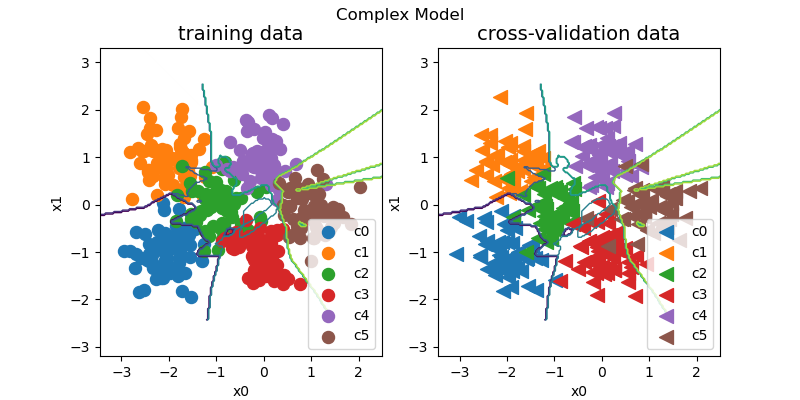

In [ ]:
#make a model for plotting routines to call
# model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)

def model_predict(Xl): 
    result = np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
    print(result[:5])
    return result

def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    #plot the decison boundary.
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("training data", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[0], X_train,y_train, classes, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes, 
                legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1"); 
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()
    
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [ ]:
def eval_cat_err(y_train: np.ndarray, yhat: np.ndarray): 
    m = len(y_train)
    err = 0
    for i in range(m): 
        if y_train[i] != yhat[i]: 
            err += 1
    return err /m
    

In [ ]:
np.argmax(tf.nn.softmax(model.predict(X_train)))

 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 686us/step


15

In [ ]:
model_predict(X_train)

13/13 [==============================] - 0s 621us/step


array([1, 3, 3, 2, 1, 3, 5, 3, 3, 0, 0, 5, 5, 0, 3, 4, 4, 1, 2, 5, 1, 0,
       5, 0, 1, 3, 1, 0, 3, 1, 5, 4, 3, 1, 1, 4, 2, 1, 5, 0, 3, 4, 3, 1,
       5, 1, 2, 4, 1, 2, 3, 2, 4, 0, 1, 1, 1, 2, 2, 4, 0, 5, 0, 0, 2, 5,
       1, 5, 2, 1, 3, 2, 5, 4, 0, 2, 3, 3, 3, 1, 2, 0, 5, 5, 4, 2, 4, 5,
       3, 5, 0, 4, 1, 3, 2, 3, 4, 2, 1, 2, 4, 4, 3, 4, 4, 5, 4, 5, 3, 4,
       3, 4, 2, 0, 0, 0, 0, 5, 4, 5, 3, 2, 4, 2, 5, 3, 5, 2, 3, 5, 0, 0,
       2, 4, 2, 0, 0, 3, 1, 1, 2, 4, 5, 5, 3, 5, 4, 0, 2, 4, 5, 1, 1, 4,
       5, 2, 2, 1, 1, 4, 1, 1, 3, 4, 1, 4, 5, 5, 1, 5, 4, 1, 3, 5, 3, 4,
       0, 1, 5, 2, 3, 2, 1, 2, 1, 0, 2, 3, 4, 5, 1, 3, 3, 5, 2, 1, 5, 5,
       1, 2, 1, 4, 3, 3, 5, 1, 2, 1, 3, 5, 2, 1, 0, 0, 1, 3, 2, 4, 2, 3,
       4, 5, 0, 2, 2, 3, 1, 1, 0, 0, 2, 5, 5, 3, 1, 2, 0, 2, 0, 3, 4, 5,
       3, 0, 1, 1, 0, 1, 1, 0, 1, 0, 5, 0, 1, 4, 0, 0, 4, 1, 4, 4, 1, 3,
       5, 3, 1, 5, 2, 0, 1, 3, 1, 3, 0, 2, 5, 1, 1, 4, 4, 2, 1, 0, 3, 4,
       5, 5, 1, 0, 3, 1, 4, 2, 3, 5, 0, 0, 0, 2, 4,

In [ ]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))

13/13 [==============================] - 0s 675us/step


array([[5.5350935e-16, 9.9935538e-01, 6.4459204e-04, 3.5734776e-32,
        7.8587518e-12, 6.5954295e-27],
       [1.8314144e-04, 9.5623204e-18, 9.6566154e-08, 5.6501049e-01,
        3.7231821e-24, 4.3480629e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.9573776e-12],
       ...,
       [4.9172989e-08, 2.9499097e-07, 9.9970776e-01, 2.9155827e-04,
        3.2549394e-07, 4.5595527e-08],
       [3.1454091e-35, 0.0000000e+00, 5.5363769e-18, 0.0000000e+00,
        1.0000000e+00, 8.0683545e-34],
       [9.9120516e-01, 5.9968237e-12, 8.7948795e-03, 3.3976474e-10,
        1.0438419e-24, 6.9322765e-16]], dtype=float32)